In [1]:
!pip install -q torch torchvision torchaudio catboost pandas transformers[torch] evaluate

You should consider upgrading via the '/home/alexander/Desktop/ml2024/snd_contest_1/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import catboost as cb
import pylab as plt
from tqdm import tqdm

In [3]:
data = pd.read_csv('train.csv')
data.head()

,text,rating
0,"Выбор чисто на 3/5. Магазинов мало, развлечени...",3.0
1,"Сегодня, 25.05.2023 заказывал шаурму в тарелке...",5.0
2,"Ходила сегодня первый раз, записывалась через ...",5.0
3,"Ремонтировали тут айфон ХS, меняли камеру и эк...",5.0
4,"Очень уютный кинотеатр, как любой другой от ко...",5.0


# Обучим "в лоб" катбуст
Жизнь слишком коротка, чтобы чистить или даже просматривать данные, просто жахнем обучение, а с качеством - будь что будет. 

In [4]:
params = {
    'loss_function': 'MAE',
    'iterations': 150,
    'random_seed': 42,
    'learning_rate': 0.05
}

pool = cb.Pool(data[['text']], data.rating, text_features=['text'])
cv_res = cb.cv(
  params=params, 
  pool=pool, 
  early_stopping_rounds=30, 
  fold_count=5, 
  shuffle=True, 
  partition_random_seed=0,
  plot=True, 
  stratified=True, 
  verbose=False,
  return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4613197061
bestIteration = 149

Training on fold [1/5]

bestTest = 0.4580813568
bestIteration = 149

Training on fold [2/5]

bestTest = 0.4573849493
bestIteration = 149

Training on fold [3/5]

bestTest = 0.4576870433
bestIteration = 149

Training on fold [4/5]

bestTest = 0.4580195776
bestIteration = 149



In [5]:
cv_res

(     iterations  test-MAE-mean  test-MAE-std  train-MAE-mean  train-MAE-std
 0             0       4.231884      0.000108        4.231883       0.000107
 1             1       3.995066      0.000864        3.995049       0.000841
 2             2       3.769738      0.001082        3.769721       0.001066
 3             3       3.555979      0.001088        3.555956       0.001069
 4             4       3.370099      0.000628        3.370081       0.000622
 ..          ...            ...           ...             ...            ...
 145         145       0.459154      0.001622        0.458168       0.000870
 146         146       0.458979      0.001577        0.457986       0.000861
 147         147       0.458770      0.001531        0.457768       0.000860
 148         148       0.458620      0.001573        0.457614       0.000857
 149         149       0.458499      0.001602        0.457487       0.000824
 
 [150 rows x 5 columns],
  <catboost.core.CatBoost at 0x7b8a201b9ca0>])

Ну везде примерно 0.45 средняя абсолютная ошибка. Помним, что жизнь коротка: отдельного валсета мы  от трейна не отщепили и теперь не можем в честном сетапе глянуть глазами как оно предсказывает на новых данных. Не можем чекнуть перфоманс на единицах и пятёрках отдельно. В рамках текущей демнострации предлагается с этим просто смириться. Что ж, сделаем сабмит:

In [6]:
df_sub = pd.read_csv('test.csv')
df_sub.head()

,ID,text
0,240021,Хорошая и качественная выпечка и шавуха. Одна...
1,345218,"Была у вас в гостях недавно в первый раз, подр..."
2,201829,Любим посещать остров сокровищ. Постоянно здес...
3,458075,Хочу выразить благодарность автошколе «Позитив...
4,5940,"Всё супер! Очень вежливые сотрудники, как к р..."


In [7]:
model = cv_res[1][0]
preds = model.predict(df_sub[['text']])

Глянем на предсказания:

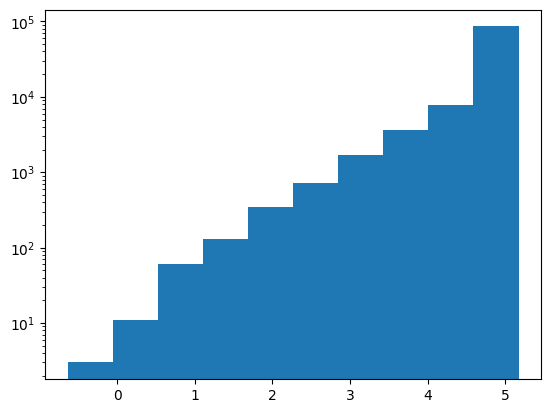

In [8]:
ax = plt.gca()
ax.hist(preds)
ax.set_yscale('log')

Штош, они как минимум разные. Решено, засылаем!

In [9]:
df_sub['rating'] = preds
df_sub[['ID', 'rating']].to_csv('sub.csv', index=False)

# Воспользуемся предобученной трансформерной моделью для перевода предложений в векторы

Например [этой](https://huggingface.co/cointegrated/rubert-tiny2). А потом попробуем поверх векторов что-нибудь дообучить под предсказание рейтинга.

In [10]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
text_to_vec_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
text_to_vec_model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt',) # разобьём текст на токены из словаря, на котором училась модель
    with torch.no_grad():  # градиенты не нужны, мы пока не учимся, а просто прогоняем данные через модель. Сэкономим памяти.
        model_output = model(**{k: v.to(model.device) for k, v in t.items()}) # Это мы результат токенизации на ГПУ перегоняем, если надо и в модельку перелаём 
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)  # Нормализуем эмбеддинги, чтобы они были с единичной сферы. 
    # Теперь не придётся в дальнейшем думать, чувствительны ли наши алгоритмы к норме векторов
    return embeddings.cpu().numpy()

In [11]:
maybe_vector = embed_bert_cls("это точно работает?", text_to_vec_model, tokenizer)
print(maybe_vector[:, :10], maybe_vector.shape)

[[ 0.03994568 -0.00592288  0.01523517 -0.04026827 -0.02025329 -0.00433577
   0.01105824  0.02046457  0.0070199   0.04463923]] (1, 312)


In [12]:
tokenizer("А токенайзер что отдаёт?", padding=True, truncation=True, return_tensors='pt')

{'input_ids': tensor([[    2,   280, 24302,  2317,   775, 18125,  1046, 59853,    35,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

`input ids` - это номера в словаре для токенов, на которые разбился наш текст. [token_type_ids](https://huggingface.co/transformers/v3.2.0/glossary.html#token-type-ids) нам для задачи "просто сделай векторы из обычных текстов" не важны, а `attention_mask` из единичек разрешает модели "смотреть" через механизм attention на всё предложение, когда она будет обрабатывать конкретные токены из последовательности, которую мы им скормим.

Сделаем векторы из наших текстов.

In [13]:
batch_size = 16  # если используется ГПУ и падает по CUDA out of memory, то размер батча можно уменьшить
vectors = []
for i in tqdm(range(0,int(len(data)/batch_size))):
    data_batch = data['text'][i*batch_size: (i+1)*batch_size].tolist()
    embeddings = embed_bert_cls(data_batch, text_to_vec_model, tokenizer)
    vectors.extend(embeddings)
   

100%|██████████| 25000/25000 [02:45<00:00, 151.07it/s]


In [14]:
vectors[0].shape, len(vectors), len(data)

((312,), 400000, 400000)

Засунем векторы в точно такой же катбуст.

In [15]:
params = {
    'loss_function': 'MAE',
    'iterations': 150,
    'random_seed': 42,
    'learning_rate': 0.05
}

pool = cb.Pool(vectors, data.rating)
cv_res = cb.cv(
  params=params, 
  pool=pool, 
  early_stopping_rounds=30, 
  fold_count=5, 
  shuffle=True, 
  partition_random_seed=0,
  plot=True, 
  stratified=True, 
  verbose=False,
  return_models=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3816491399
bestIteration = 149

Training on fold [1/5]

bestTest = 0.3801046379
bestIteration = 149

Training on fold [2/5]

bestTest = 0.3777807693
bestIteration = 149

Training on fold [3/5]

bestTest = 0.3785934981
bestIteration = 149

Training on fold [4/5]

bestTest = 0.3793707346
bestIteration = 149



Стало 0.38! Сделаем сабмишен, не забыв векторизовать данные.

In [16]:
model = cv_res[1][0]

batch_size = 16  # если используется ГПУ и падает по CUDA out of memory, то размер батча можно уменьшить
vectors_sub = []
for i in tqdm(range(0,int(len(df_sub)/batch_size))):
    data_batch = df_sub['text'][i*batch_size: (i+1)*batch_size].tolist()
    embeddings = embed_bert_cls(data_batch, text_to_vec_model, tokenizer)
    vectors_sub.extend(embeddings)
   
preds = model.predict(vectors_sub)
df_sub['rating'] = preds
df_sub[['ID', 'rating']].to_csv('sub_bert_catboost.csv', index=False)

100%|██████████| 6250/6250 [00:40<00:00, 152.74it/s]


# Deep learning

Наконец, попробуем дообучить нашу модель под именно наши данные и нашу задачу и посмотреть, окажет ли это эффект. Будем заставлять модельку напрямую прогнозировать наш рейтинг, не наворачивая поверх катбуст. 

Кросс-валидация тут будет дорогой: трансформерные модельки учатся существенно дольше, чем катбуст, так что отщепим кусочек данных для тестирования нашего перфоманса


Ниже не будет готового решения, лишь несколько импортов, чтобы указать куда копать. Результат, который можно выбить на этом пути разумными усилиями можно увидеть в лидерборде от участника Alexander :)

In [45]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.15, stratify=data['rating'])

Для того, чтобы стандартный инструмент для трейна моделей из библиотеки transformers работал, и нам не надо было руками писать трейнлуп и логирование, завернём наши данные в класс Dataset, а его в Dataloader. Их два, т.к. датасет описывает как из сырцов получать данные для модели, а даталоадер - это про эффективную итерацию, prefetch и тому подобное 

In [19]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.max_length = max_length
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]

        tokens = tokenizer(review, padding='max_length', truncation=True, return_tensors='pt',max_length=self.max_length)

        return {
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [20]:
train_dataset = CustomDataset(train['text'].values, train['rating'].values, tokenizer, 256)
test_dataset = CustomDataset(test['text'].values, test['rating'].values, tokenizer, 256)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True) # если используется ГПУ и падает по CUDA out of memory, то размер батча можно уменьшить
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False) # если используется ГПУ и падает по CUDA out of memory, то размер батча можно уменьшить